In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)



In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

In [10]:
# Inspect the column names of 'Measurement' table
inspector = inspect(engine)
inspector.get_table_names()
measurement_columns = inspector.get_columns('Measurement')
for measurement_column in measurement_columns:
    print(measurement_column["name"], measurement_column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspect the column names of 'Station' table
station_columns = inspector.get_columns('Station')
for station_column in station_columns:
    print(station_column["name"], station_column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
date = session.query(Measurement.date).limit(5).all()
date

[('2010-01-01'),
 ('2010-01-02'),
 ('2010-01-03'),
 ('2010-01-04'),
 ('2010-01-06')]

In [13]:
# Total dates
total_date = session.query(func.count(Measurement.date)).all()
total_date

[(19550)]

In [75]:
# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
yearFrom_latest_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

print(yearFrom_latest_date)

2016-08-23


<Figure size 1080x720 with 0 Axes>

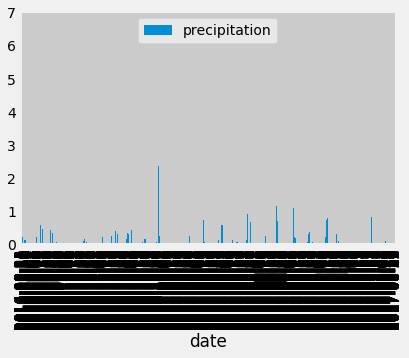

In [30]:

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns = ["date", "precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(["date"])

precipitation_df = precipitation_df.set_index("date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize = (15,10))
precipitation_df.plot.bar()




In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [65]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).distinct().count()
print(f"{station_count} stations are available in this dataset.")

9 stations are available in this dataset.


In [105]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# selection = [Station.station,
#             func.count(Measurement.station)]
active_station = session.query(Station.station, func.count(Measurement.station)).\
                join(Station, Station.station == Measurement.station).\
                group_by(Station.station).\
                order_by(func.count(Measurement.station).desc()).all()
#                 all()
for result in active_station:
    print(f"Station name : {result[0]}")
    print(f"Count : {result[1]}")
    print("---------------------------")

Station name : USC00519281
Count : 2772
---------------------------
Station name : USC00519397
Count : 2724
---------------------------
Station name : USC00513117
Count : 2709
---------------------------
Station name : USC00519523
Count : 2669
---------------------------
Station name : USC00516128
Count : 2612
---------------------------
Station name : USC00514830
Count : 2202
---------------------------
Station name : USC00511918
Count : 1979
---------------------------
Station name : USC00517948
Count : 1372
---------------------------
Station name : USC00518838
Count : 511
---------------------------


In [106]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = "USC00519281"
temp_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter_by(station = most_active_station).all()

for temp in temp_active_station:
    print(f"Lowest temperature recorded for station {most_active_station} is {temp_active_station[0][0]} F.")
    print(f"Highest temperature recorded for station {most_active_station} is {temp_active_station[0][1]} F.")
    print(f"Average temperature for station {most_active_station} is {round(temp_active_station[0][2], 2)} F.")

Lowest temperature recorded for station USC00519281 is 54.0 F.
Highest temperature recorded for station USC00519281 is 85.0 F.
Average temperature for station USC00519281 is 71.66 F.


In [107]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_observation = session.query(Measurement.date, Measurement.tobs).\
                            filter_by(station = most_active_station).\
                            filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).\
                            all()

active_station_df = pd.DataFrame(active_station_observation, columns = ["date", "temperature"])
active_station_df = active_station_df.set_index("date")
active_station_df.head()


,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


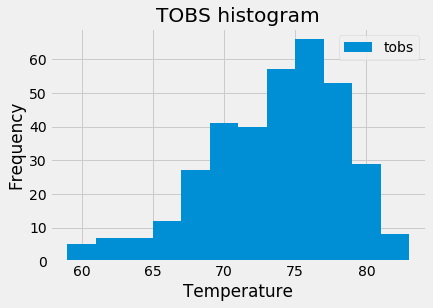

In [117]:

active_station_df.hist(bins =12)

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc = "upper right")
plt.title("TOBS histogram")
plt.show()


## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
